In [1]:
from craft_text_detector import Craft
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
%matplotlib inline
from matplotlib import pyplot as plt
import pytesseract

from alice.config import PROCESSING_INPUT_DIR
from alice.predict import predict_masks
from alice.visualise import visualise_mask
from alice.utils import *
from collections import OrderedDict
from itertools import zip_longest

In [20]:
craft = Craft(crop_type="box", cuda=False)

In [14]:
image1 = cv2.imread("image1.jpg")
image1 = cv2.imread("image1.jpg")

In [15]:
prediction_result = craft.detect_text(image)

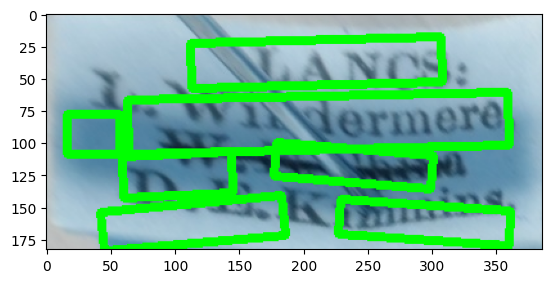

(<matplotlib.image.AxesImage at 0x154319b70>, None)

In [43]:
image1 = cv2.imread("image1.jpg")
prediction_result1 = craft.detect_text(image1)
img = image.copy()

for box in prediction_result1['boxes']:
    points = box.astype(int).reshape((-1, 1, 2))
    cv2.polylines(img, [points], True, (0,255,0), 5) 

plt.imshow(img), plt.show()

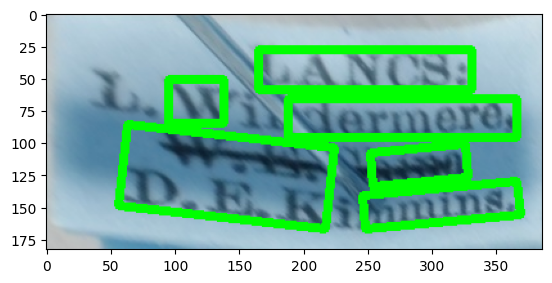

(<matplotlib.image.AxesImage at 0x15442c0d0>, None)

In [45]:
image2 = cv2.imread("image2.jpg")
prediction_result2 = craft.detect_text(image2)
img = image.copy()

for box in prediction_result2['boxes']:
    points = box.astype(int).reshape((-1, 1, 2))
    cv2.polylines(img, [points], True, (0,255,0), 5) 

plt.imshow(img), plt.show()

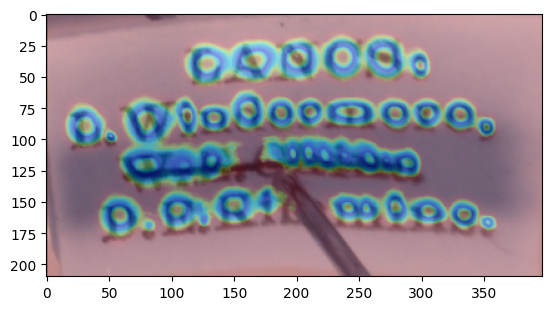

(<matplotlib.image.AxesImage at 0x1544991e0>, None)

In [46]:

# img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
# img = cv2.applyColorMap(prediction_result['heatmaps'], cv2.COLORMAP_JET)

# # plt.matshow(prediction_result['heatmaps'])
# plt.show()


heatmap = prediction_result1["heatmaps"]['text_score_heatmap']


heatmap_resized = cv2.resize(heatmap, (image1.shape[1], image1.shape[0]))


# Apply a color map to the normalized heatmap
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Overlay the colored heatmap onto the original image
output_image = cv2.addWeighted(image1, 0.7, heatmap_colored, 0.3, 0)

plt.imshow(output_image), plt.show()

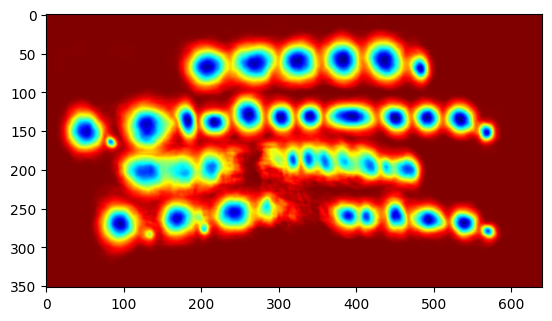

(<matplotlib.image.AxesImage at 0x15638cdf0>, None)

In [56]:
heatmap = prediction_result2["heatmaps"]['text_score_heatmap']


heatmap_resized = cv2.resize(heatmap, (image2.shape[1], image2.shape[0]))


# Apply a color map to the normalized heatmap
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Overlay the colored heatmap onto the original image
output_image = cv2.addWeighted(image2, 0.7, heatmap_colored, 0.3, 0)

plt.imshow(prediction_result1["heatmaps"]['text_score_heatmap']), plt.show()

/Users/ben/Projects/NaturalHistoryMuseum/ALICE/CRAFT-pytorch/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8


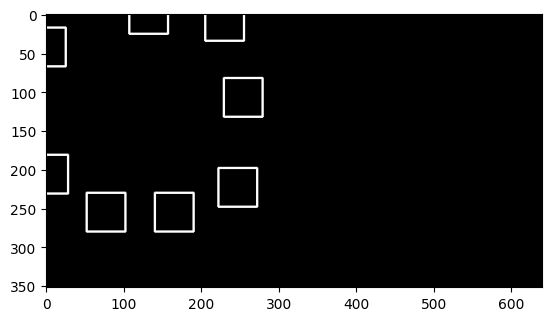

(<matplotlib.image.AxesImage at 0x15e812c50>, None)

In [76]:
heatmap_data = prediction_result1["heatmaps"]['text_score_heatmap']

num_rows, num_cols, num_channels = heatmap_data.shape
reshaped_data = heatmap_data.reshape(num_rows * num_cols, num_channels)

# Set the desired number of clusters
num_clusters = 3

# Create a KMeans instance and fit the model
kmeans = KMeans()
kmeans.fit(reshaped_data)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

print(len(cluster_centers))

# Initialize an empty image to draw rectangles on
image = np.zeros((num_rows, num_cols, num_channels), dtype=np.uint8)

box_size = 50  # Adjust this value based on your preference


# Draw rectangles around cluster centers
for center in cluster_centers:
    x, y = int(center[0]), int(center[1])
    top_left = (x - box_size // 2, y - box_size // 2)
    bottom_right = (x + box_size // 2, y + box_size // 2)
    cv2.rectangle(image, top_left, bottom_right, (255, 255, 255), 2)

plt.imshow(image), plt.show()

In [48]:
# Calculate the indices of the non-zero elements in the heatmap
indices = np.transpose(np.nonzero(heatmap))

# Calculate the weighted average of indices to find the centers
cluster_centers = np.mean(indices, axis=0, dtype=int)

In [49]:
cluster_centers

array([156, 325,   0])

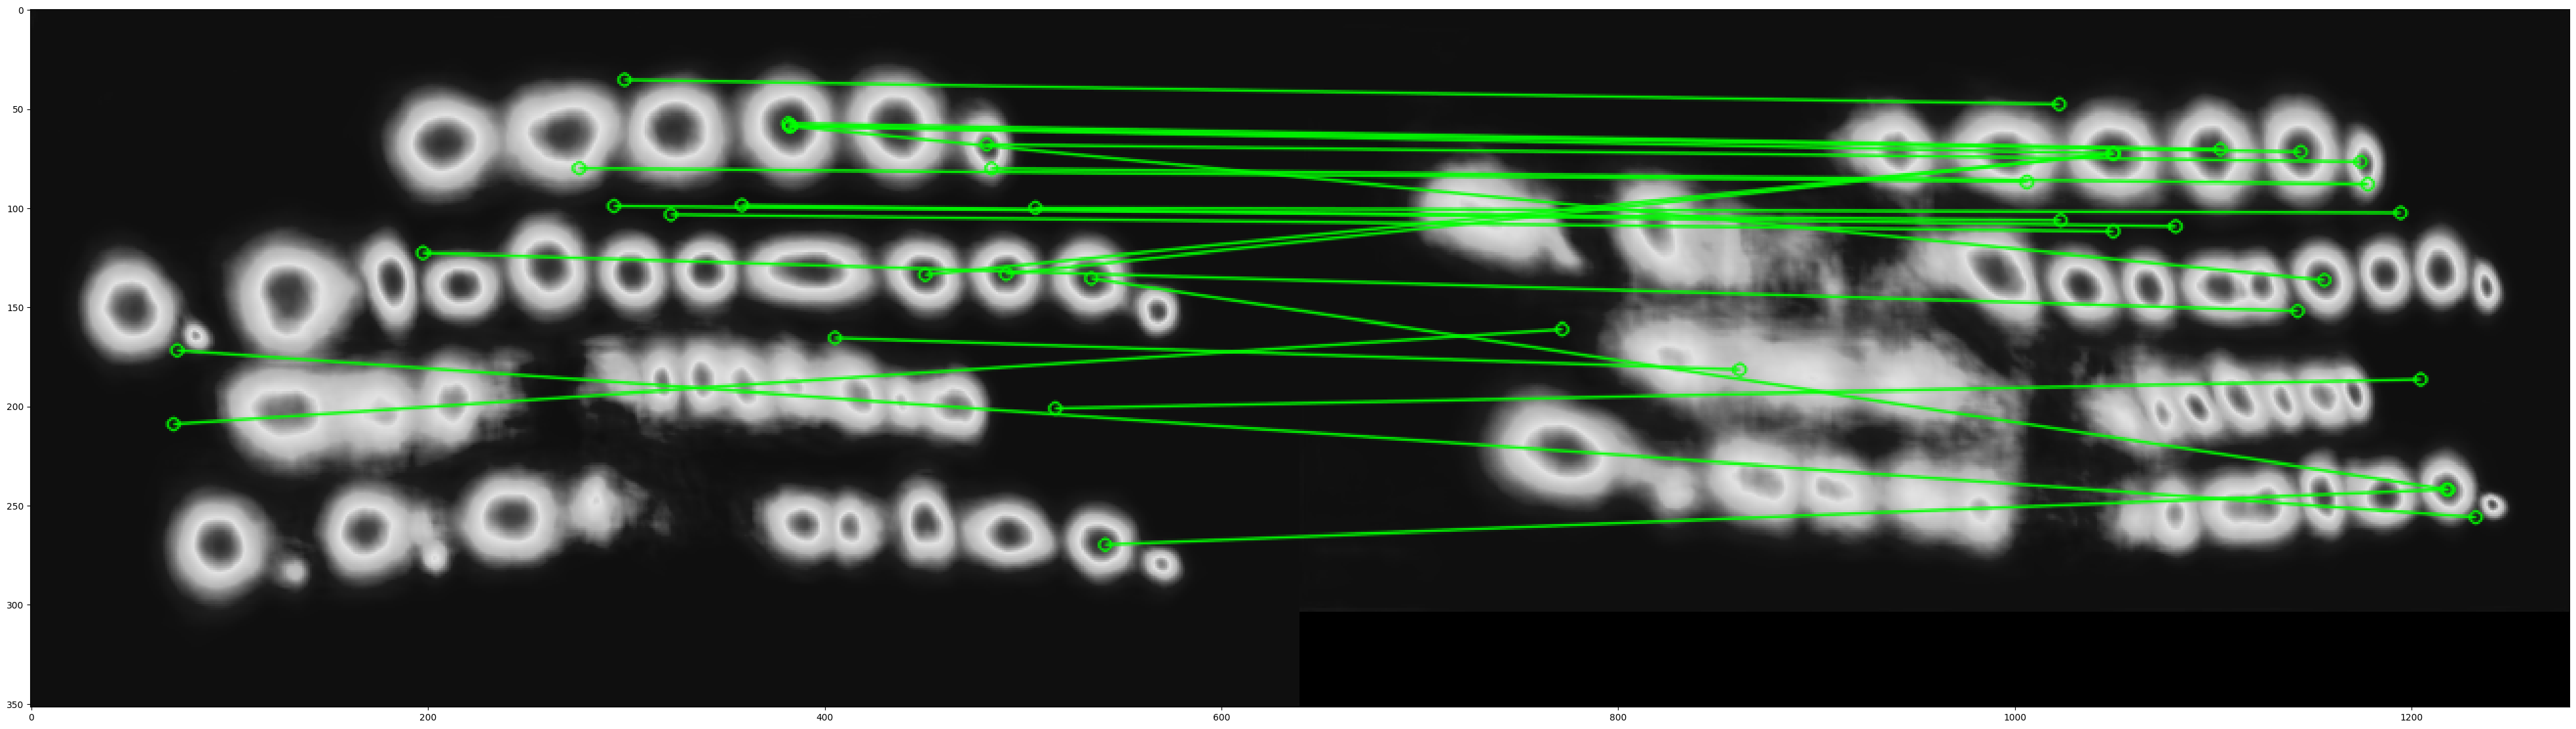

In [69]:
def sift_detector(image1, image2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create(10000)
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1,None)
    kp2, des2 = sift.detectAndCompute(image2,None)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(des1,des2,k=2)
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    return kp1, kp2, good      
    

img1 = cv2.cvtColor(prediction_result1["heatmaps"]['text_score_heatmap'], cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(prediction_result2["heatmaps"]['text_score_heatmap'], cv2.COLOR_BGR2GRAY)

kp1, kp2, good = sift_detector(img1, img2)

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()
h,w = img1.shape

transformed_img = cv2.warpPerspective(img1, M, (w, h))

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   # matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.figure(figsize = (50,20))
plt.imshow(img3, 'gray')
plt.show()

In [52]:
!pip install scikit-learn

  Using cached scikit_learn-1.3.0-cp310-cp310-macosx_10_9_x86_64.whl (10.2 MB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
     |████████████████████████████████| 302 kB 3.0 MB/s eta 0:00:01
You should consider upgrading via the '/Users/ben/Projects/NaturalHistoryMuseum/ALICE/CRAFT-pytorch/.venv/bin/python -m pip install --upgrade pip' command.


In [79]:


np.max(heatmap, axis=2)

array([[144, 152, 132, ..., 128, 132, 152],
       [136, 132, 132, ..., 128, 136, 128],
       [128, 128, 128, ..., 128, 132, 144],
       ...,
       [152, 148, 148, ..., 136, 132, 128],
       [172, 168, 172, ..., 136, 128, 128],
       [180, 172, 172, ..., 140, 148, 136]], dtype=uint8)

In [130]:
heatmap1 = np.array(cv2.cvtColor(prediction_result1["heatmaps"]['text_score_heatmap'], cv2.COLOR_BGR2GRAY))
heatmap2 = np.array(cv2.cvtColor(prediction_result2["heatmaps"]['text_score_heatmap'], cv2.COLOR_BGR2GRAY))

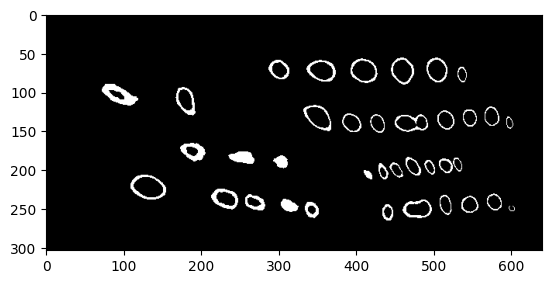

In [125]:


plt.imshow(binary_mask, 'gray')
plt.show()

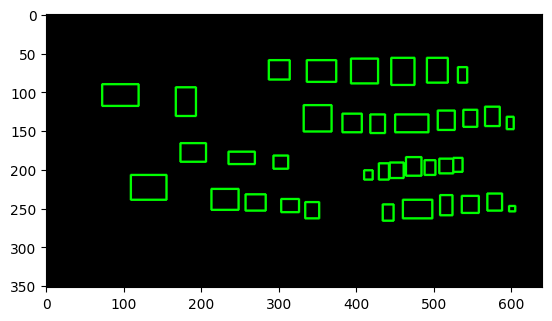

In [237]:
def heatmap_rectangles(heatmap):

    # Define the threshold value - values above this will be hotspots to draw boxes around
    threshold = 210    
    # Create a binary mask
    binary_mask = heatmap > threshold    
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rects = []
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        rects.append([(x, y), (x + w, y + h)])
        
    return np.array(rects)

rects1 = heatmap_rectangles(heatmap1)    
rects2 = heatmap_rectangles(heatmap2)   

vis = np.zeros(heatmap1.shape + (3,), dtype=np.uint8)

# # Create an image to draw the boxes on
# image_with_boxes = np.zeros(binary_mask.shape + (3,), dtype=np.uint8)

# # Draw boxes around the contours
# for contour in contours:
#     x, y, w, h = cv2.boundingRect(contour)
#     cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)


# # Create a binary mask
# binary_mask = heatmap2 > threshold
# # Find contours in the binary mask
# contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Create an image to draw the boxes on
# image_with_boxes2 = np.zeros(binary_mask.shape + (3,), dtype=np.uint8)

# rects = []

# # Draw boxes around the contours
# for contour in contours:
#     rect = [(x, y), (x + w, y + h)]
#     rects.append(rect)
    
#     x, y, w, h = cv2.boundingRect(contour)
#     cv2.rectangle(image_with_boxes2, (x, y), (x + w, y + h), (0, 255, 0), 2)

for rect in rects2:
    pt1, pt2 = rect
    cv2.rectangle(vis, pt1, pt2, (0, 255, 0), 2)

plt.imshow(vis, 'gray')
plt.show()

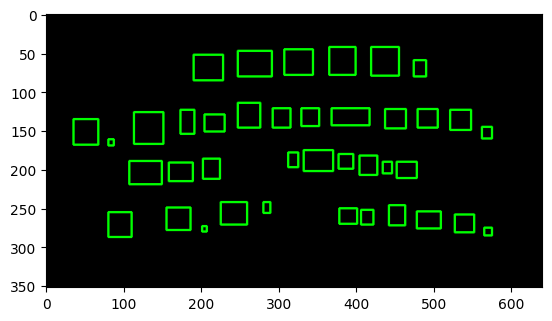

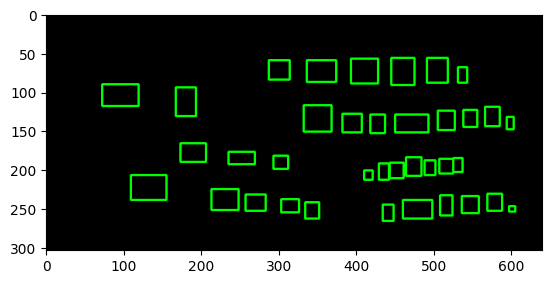

In [171]:
plt.imshow(image_with_boxes, 'gray')
plt.show()

plt.imshow(image_with_boxes2, 'gray')
plt.show()

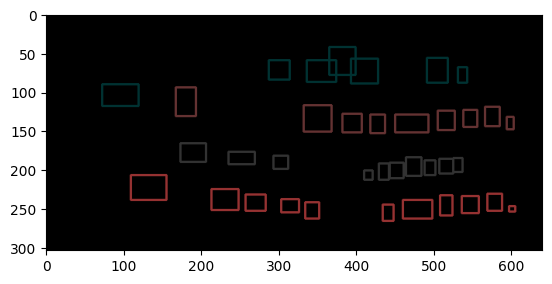

In [225]:
# Remove small boxes. Group into lines of text
# Draw line of best fit
# Put dots along that line of best fits at every 50 pixels
# Match those

import matplotlib.patches as patches

rects = np.array(rects)

vertical_midpoints = (rects[:,0,1] + rects[:,1,1]) / 2.0

# Letter baselines will have more homogeneity, so cluster using centroid of the baseline
baselines = np.array([((x1 + x2) / 2, max(y1, y2)) for (x1, y1), (x2, y2) in rects]).astype(int)

# Set the number of clusters you want to identify
num_clusters = 4

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
cluster_labels = kmeans.fit_predict(vertical_midpoints.reshape(-1, 1))

cluster_rectangles = [[] for _ in range(num_clusters)]
for i, rect in enumerate(rects):
    cluster_index = cluster_labels[i]
    cluster_rectangles[cluster_index].append(rect)

vis = np.zeros(binary_mask.shape + (3,), dtype=np.uint8)

for cluster_index, cluster in enumerate(cluster_rectangles):
    color = plt.cm.viridis(cluster_index / num_clusters)  # Different color for each cluster
    r = 50 * cluster_index
    for rect in cluster:
        pt1, pt2 = rect
        cv2.rectangle(vis, pt1, pt2, (r, 50, 50), 2)
        


        
plt.imshow(vis)
plt.show()        


In [146]:
cluster_centers

array([194.7       ,  71.25      , 131.4       , 244.81818182])

In [174]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
np.random.seed = 42
%matplotlib inline

#Generate (x,y) data
x = np.linspace(0.1,0.9,50)
y = x%1
x += np.sin(2*x%1)
y = y%0.2

#Shuffle (x,y) data
ns = list(range(len(x)))
np.random.shuffle(ns)
x = x[ns]
y = y[ns]

"""
    Fit the Data 
"""
X = [i for i in zip(x,y)]
# X = StandardScaler().fit_transform(X)

In [211]:

# Letter baseline will have more vertical homogeneity, so calculate centroid of the baseline
baselines = np.array([((x1 + x2) / 2, max(y1, y2)) for (x1, y1), (x2, y2) in rects]).astype(int)

# centroids = np.array([((x1 + x2) / 2, (y1 + y2) / 2) for (x1, y1), (x2, y2) in rects]).astype(int)


print(baselines)

# vertical_midpoints = (rects[:,0,1] + rects[:,1,1]) / 2.0

# # # Set the number of clusters you want to identify
# # num_clusters = 4

# db = DBSCAN(eps=500, min_samples=3).fit(centroids)
# labels = db.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_clusters_

[[382  78]
 [601 254]
 [441 266]
 [343 263]
 [479 263]
 [314 255]
 [547 256]
 [516 259]
 [270 253]
 [578 253]
 [230 252]
 [132 239]
 [415 213]
 [435 213]
 [452 211]
 [495 207]
 [516 205]
 [531 203]
 [474 208]
 [302 199]
 [252 193]
 [189 190]
 [598 148]
 [471 152]
 [427 153]
 [394 152]
 [516 149]
 [547 145]
 [575 144]
 [350 151]
 [180 131]
 [ 95 118]
 [537  88]
 [355  87]
 [300  84]
 [410  89]
 [504  88]]


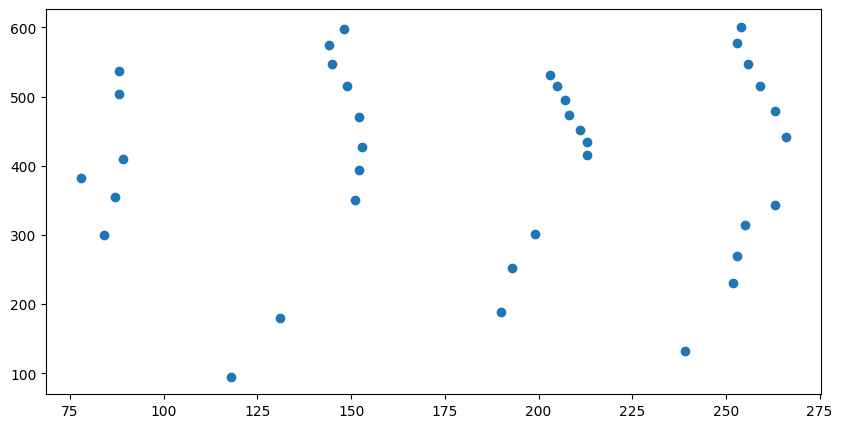

In [213]:
plt.figure(figsize=(10,5))
plt.scatter(baselines[:, 1], baselines[:, 0])

In [204]:
centroids[:,0]

array([382, 601, 441, 343, 479, 314, 547, 516, 270, 578, 230, 132, 415,
       435, 452, 495, 516, 531, 474, 302, 252, 189, 598, 471, 427, 394,
       516, 547, 575, 350, 180,  95, 537, 355, 300, 410, 504])

11
11
[221.71952388 231.93917716 240.68046938 247.94340054 253.72797063
 258.03417965 260.86202761 262.2115145  262.08264033 260.47540509
 257.38980879]


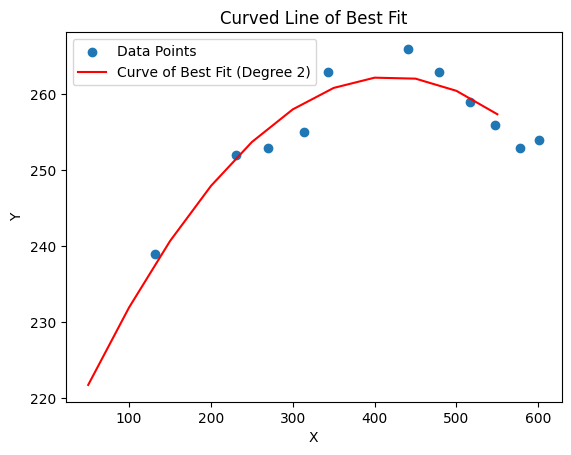

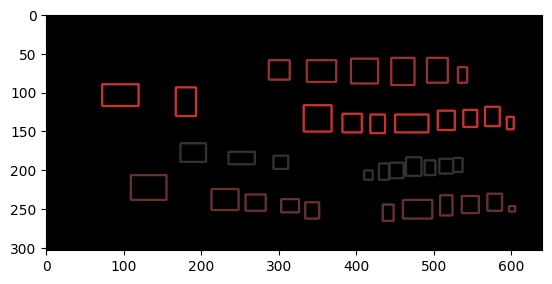

In [333]:
import matplotlib.patches as patches

# rects = np.array(rects2)

# Letter baselines will have more homogeneity, so cluster using centroid of the baseline
baselines = np.array([max(y) for y in rects[:,:, 1]])

cluster_labels = hcluster.fclusterdata(baselines.reshape(-1,1), t=4, criterion="maxclust")

cluster_rectangles = {}
for i, rect in enumerate(rects):
    cluster_index = cluster_labels[i]
    cluster_rectangles.setdefault(cluster_index, []).append(rect)

x_intervals = list(range(50, 600, 50))

for i, cluster in cluster_rectangles.items():
    baseline_centroids = np.array([
        (np.mean(rect[:, 0], dtype=np.int32), max(rect[:, 1])) for rect in cluster
    ])

    x, y = baseline_centroids.T

    print(len(x))
    print(len(y))

    # Fit a polynomial of degree 2 (quadratic)
    degree = 2
    coefficients = np.polyfit(x, y, degree)

    y_pred = np.polyval(coefficients, x_intervals)

    print(y_pred)

    # print(baseline_centroids[:,0])

    break
    

plt.scatter(x, y, label='Data Points')
plt.plot(x_intervals, y_pred, color='red', label='Curve of Best Fit (Degree 2)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Curved Line of Best Fit')
plt.legend()
plt.show()
    
# clustered = np.array(list(zip(cluster_labels, rects)))

# print(rects)
# print(type(rects2))

# for cluster_label in set(cluster_labels):
#     print(cluster_label)


# # SNumber of clusters - TODO use centence boxes?
# num_clusters = 4

# # # Perform K-Means clustering
# kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
# cluster_labels = kmeans.fit_predict(baselines.reshape(-1, 1))

# clustered = list(zip(cluster_labels, rects))

# vis = np.zeros(binary_mask.shape + (3,), dtype=np.uint8)

# for cluster_index, rect in clustered:
#     r = 50 * int(cluster_index) + 1
#     pt1, pt2 = rect
#     cv2.rectangle(vis, pt1, pt2, (r, 50, 50), 2)

# # print(list(clustered))

# # clustered = [[] for _ in range(len(cluster_labels))]
# # for i, rect in enumerate(rects2):
# #     cluster_index = cluster_labels[i]
# #     clustered[cluster_index].append(rect)
    
# # vis = np.zeros(binary_mask.shape + (3,), dtype=np.uint8)

# # for rect in rects2:
# #     pt1, pt2 = rect
# #     cv2.rectangle(vis, pt1, pt2, (0, 255, 0), 2)

# # for cluster_index, cluster in enumerate(clustered):
# #     # color = plt.cm.viridis(cluster_index / num_clusters)  # Different color for each cluster
# #     r = 50 * cluster_index


        


        
plt.imshow(vis)
plt.show()  

# # cluster_rectangles = [[] for _ in range(num_clusters)]
# # for i, rect in enumerate(rects):
# #     cluster_index = cluster_labels[i]
# #     cluster_rectangles[cluster_index].append(rect)



# # for cluster_index, cluster in enumerate(cluster_rectangles):
# #     color = plt.cm.viridis(cluster_index / num_clusters)  # Different color for each cluster
# #     r = 50 * cluster_index
# #     for rect in cluster:
# #         pt1, pt2 = rect
# #         cv2.rectangle(image_with_boxes2, pt1, pt2, (r, 50, 50), 2)
        

# # plt.imshow(image_with_boxes2)
# # plt.show()        


In [328]:
list(range(50, 500, 50))

[50, 100, 150, 200, 250, 300, 350, 400, 450]

In [304]:
existing_array = np.array([[1, 2], [3, 4], [5, 6]])
new_column = [7, 8, 9]

new_array = np.column_stack((existing_array, new_column))
# print(new_array)

rects

array([[[597, 247],
        [605, 254]],

       [[434, 245],
        [448, 266]],

       [[334, 242],
        [352, 263]],

       [[460, 239],
        [498, 263]],

       [[303, 238],
        [326, 255]],

       [[536, 234],
        [558, 256]],

       [[508, 233],
        [524, 259]],

       [[257, 232],
        [283, 253]],

       [[569, 231],
        [588, 253]],

       [[213, 225],
        [248, 252]],

       [[109, 207],
        [155, 239]],

       [[410, 201],
        [421, 213]],

       [[429, 192],
        [442, 213]],

       [[443, 191],
        [461, 211]],

       [[488, 188],
        [502, 207]],

       [[507, 186],
        [525, 205]],

       [[525, 185],
        [537, 203]],

       [[464, 184],
        [484, 208]],

       [[293, 182],
        [312, 199]],

       [[235, 177],
        [269, 193]],

       [[173, 166],
        [206, 190]],

       [[594, 132],
        [603, 148]],

       [[450, 129],
        [493, 152]],

       [[418, 129],
        [437, 

In [292]:
!pip install pandas

  Using cached pandas-2.0.3-cp310-cp310-macosx_10_9_x86_64.whl (11.8 MB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
You should consider upgrading via the '/Users/ben/Projects/NaturalHistoryMuseum/ALICE/CRAFT-pytorch/.venv/bin/python -m pip install --upgrade pip' command.


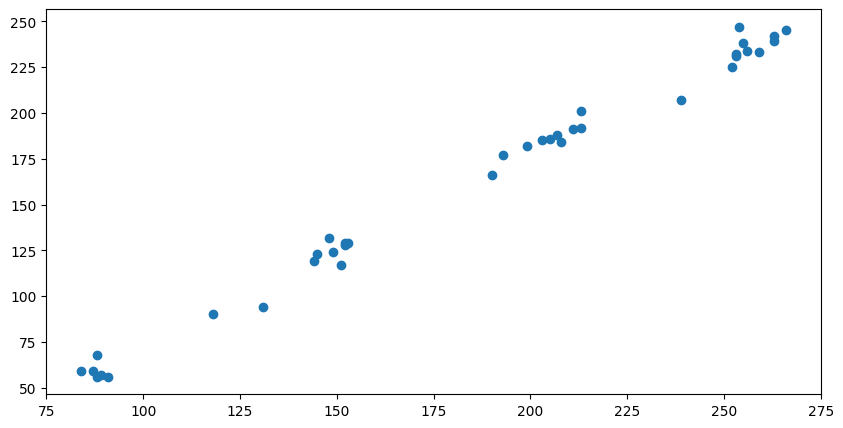

In [271]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.scatter(ys[:, 1], ys[:, 0])


4


(0.0, 630.0)

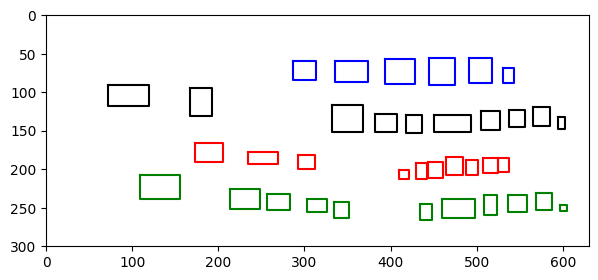

In [283]:
import scipy.cluster.hierarchy as hcluster

boxes_y1 = []

boxes = rects

for b in rects:
    boxes_y1.append(b[:,1][1])
    
boxes_y1 = np.array(boxes_y1)

thresh = 15
clusters = hcluster.fclusterdata(boxes_y1.reshape(-1,1), t=4, criterion="maxclust")
print(len(np.unique(clusters)))

cols2 = {}
cols2[1] = 'r'
cols2[2] = 'g'
cols2[3] = 'b'
cols2[4] = 'k'
cols2[5] = 'y'

 

fig,ax = plt.subplots(figsize=(7,3))

 

for i,b in enumerate(boxes):
    x = [b[0][0],b[0][0],b[1][0],b[1][0],b[0][0]]
    y = [b[0][1],b[1][1],b[1][1],b[0][1],b[0][1]]
    col = cols2[clusters[i]]
    ax.plot(x,y,color=col)

ax.set_ylim([300,0])
ax.set_xlim([0,630])


In [284]:
boxes_y1

array([254, 266, 263, 263, 255, 256, 259, 253, 253, 252, 239, 213, 213,
       211, 207, 205, 203, 208, 199, 193, 190, 148, 152, 153, 152, 149,
       145, 144, 151, 131, 118,  88,  87,  84,  89,  88,  91])